In [37]:
import numpy as np
np.random.seed(88889999)
import graspy
from graspy.inference import NonparametricTest
from graspy.embed import AdjacencySpectralEmbed
from scipy.linalg import orthogonal_procrustes
from graspy.simulations import sbm, rdpg
from graspy.utils import symmetrize
from graspy.plot import heatmap, pairplot
from tqdm import tqdm
import matplotlib.pyplot as plt; plt.style.use('classic')
import seaborn as sns; sns.set()

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [52]:
def reflect(X1, X2):
    X1_medians = np.median(X1, axis=0)
    X2_medians = np.median(X2, axis=0)        
    val = np.multiply(X1_medians, X2_medians)
    t = (val > 0) * 2 - 1
    X1 = np.multiply(t.reshape(-1, 1).T, X1)
    return X1, X2

def diff_old(X1, X2, mode='n'):
    if mode == 'p':
        R = orthogonal_procrustes(X1, X2)[0]
        return np.linalg.norm(X1 @ R - X2)
    elif mode == 'r':
        X1, X2 = reflect(X1, X2)
        return np.linalg.norm(X1 - X2)
    elif mode == 'rp':
        X1, X2 = reflect(X1, X2)
        R = orthogonal_procrustes(X1, X2)[0]
        return np.linalg.norm(X1 @ R - X2)
    elif mode == 'n':
        return np.linalg.norm(X1 - X2)

def diff(X1, X2, mode='n'):
    npt = NonparametricTest(n_components=2)
    A1 = rdpg(X1, loops=False, rescale=False, directed=False)
    A2 = rdpg(X2, loops=False, rescale=False, directed=False)
    X1_hat, X2_hat = npt._embed(A1, A2)
    if mode == 'p':
        R = orthogonal_procrustes(X1_hat, X2_hat)[0]
        X1_hat = X1_hat @ R
        return npt._statistic(X1_hat, X2_hat)
    elif mode == 'r':
        X1_hat, X2_hat = npt._median_heuristic(X1_hat, X2_hat)
        return npt._statistic(X1_hat, X2_hat)
    elif mode == 'rp':
        X1_hat, X2_hat = npt._median_heuristic(X1_hat, X2_hat)
        R = orthogonal_procrustes(X1_hat, X2_hat)[0]
        X1_hat = X1_hat @ R
        return npt._statistic(X1_hat, X2_hat)
    elif mode == 'n':
        return npt._statistic(X1_hat, X2_hat)
    else:
        raise ValueError()
        
def diffs(X1, X2):
    d = {}
    d['none'] = diff(X1, X2, 'n')
    d['reflect'] = diff(X1, X2, 'r')
    d['procrust'] = diff(X1, X2, 'p')
    d['reflect-procrust'] = diff(X1, X2, 'rp')
    return d

def gen_data(a1, a2, d, n=100):
    X1 = np.random.uniform(a1[0], a1[1], (n,d))
    X2 = np.random.uniform(a2[0], a2[1], (n,d))
    return X1, X2

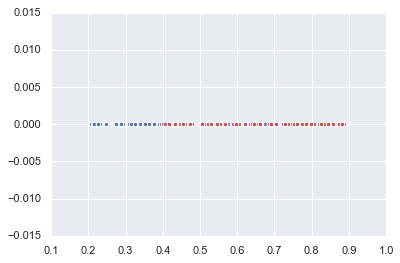

In [76]:
X1_1, X2_1 = gen_data([.2, .7], [.4, .9], 1)
plt.scatter(X1_1, [0] * len(X1_1))
plt.scatter(X2_1, [0] * len(X2_1), c = 'r')
plt.show()

In [77]:
d = diffs(X1_1, X2_1)
print(d)

{'none': 0.10869372247150944, 'reflect': 0.09808102884174963, 'procrust': 0.12816011087269852, 'reflect-procrust': 0.09046220521902315}


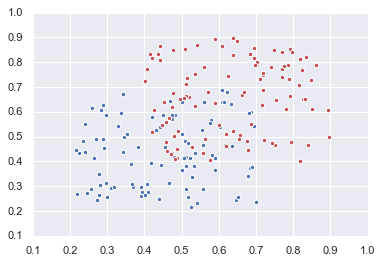

In [145]:
X1_2, X2_2 = gen_data([.2, .7], [.4, .9], 2)
plt.scatter(X1_2[:,0],X1_2[:,1])
plt.scatter(X2_2[:,0],X2_2[:,1],c='r')
plt.show()

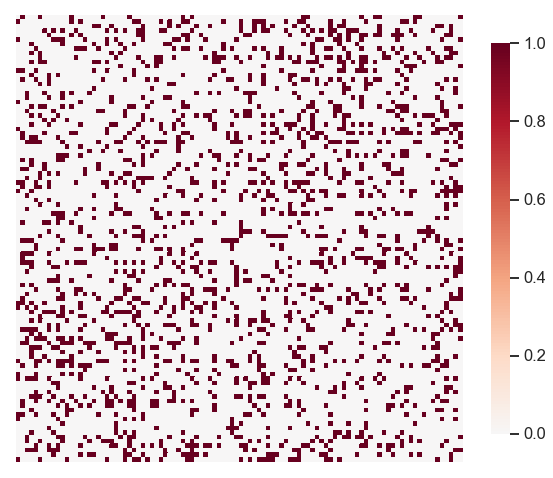

In [146]:
npt = NonparametricTest(n_components=2)
A1 = rdpg(X1_1, loops=False, rescale=False, directed=False)
A2 = rdpg(X2_2, loops=False, rescale=False, directed=False)
heatmap(A1)

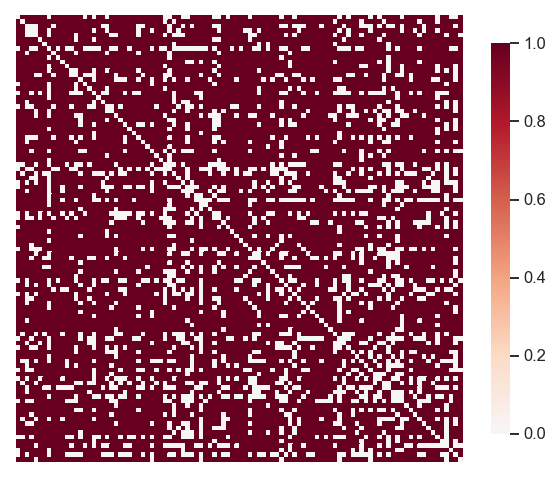

In [147]:
heatmap(A2)

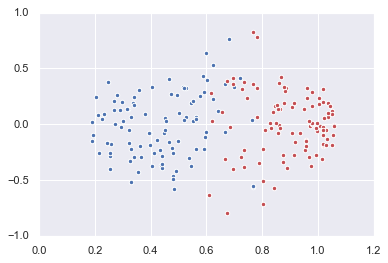

In [151]:
X1_hat = AdjacencySpectralEmbed(n_components=2).fit_transform(A1)
X2_hat = AdjacencySpectralEmbed(n_components=2).fit_transform(A2)
plt.scatter(X1_hat[:,0],X1_hat[:,1])
plt.scatter(X2_hat[:,0],X2_hat[:,1],c='r')
plt.show()

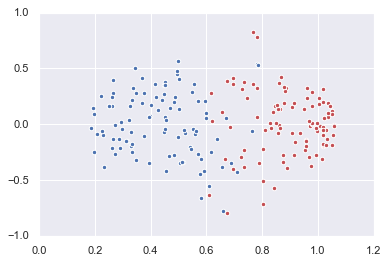

In [150]:
R = orthogonal_procrustes(X1_hat, X2_hat)[0]
X1_hat_2 = X1_hat @ R
plt.scatter(X1_hat_2[:,0],X1_hat_2[:,1])
plt.scatter(X2_hat[:,0],X2_hat[:,1],c='r')
plt.show()

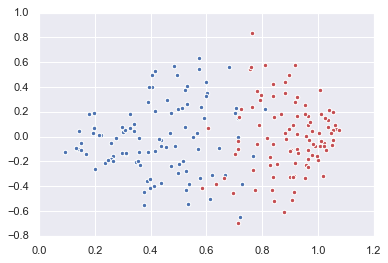

In [131]:
X1_hat_3, X2_hat_3 = npt._median_heuristic(X1_hat, X2_hat)
plt.scatter(X1_hat_3[:,0],X1_hat_3[:,1])
plt.scatter(X2_hat_3[:,0],X2_hat_3[:,1],c='r')
plt.show()

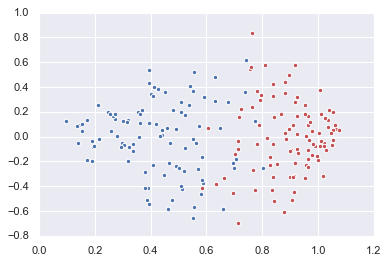

In [132]:
R = orthogonal_procrustes(X1_hat_3, X2_hat_3)[0]
X1_hat_4 = X1_hat_3 @ R
plt.scatter(X1_hat_4[:,0],X1_hat_4[:,1])
plt.scatter(X2_hat_3[:,0],X2_hat_3[:,1],c='r')
plt.show()

In [133]:
d = diffs(X1_2, X2_2)
print(d)

{'none': 0.2165438476228685, 'reflect': 0.1852601218384864, 'procrust': 0.16980682082498133, 'reflect-procrust': 0.17469226553675743}


In [134]:
a = [.2, .7]
l = {'none':[], 'reflect':[], 'procrust':[], 'reflect-procrust':[]}
for a22 in tqdm(range(-10,10,1)):
    n = []
    r = []
    p = []
    rp = []
    for b22 in range(-10,10,1):
        a2 = a22/10.
        b2 = b22/10.
        X1, X2 = gen_data(a, [a2, b2], 2)
        d = diffs(X1, X2)
        n.append(d['none'])
        r.append(d['reflect'])
        p.append(d['procrust'])
        rp.append(d['reflect-procrust'])
    l['none'].append(n)
    l['reflect'].append(r)
    l['procrust'].append(p)
    l['reflect-procrust'].append(rp)

100%|██████████| 20/20 [01:22<00:00,  4.22s/it]


0.2208589690765425


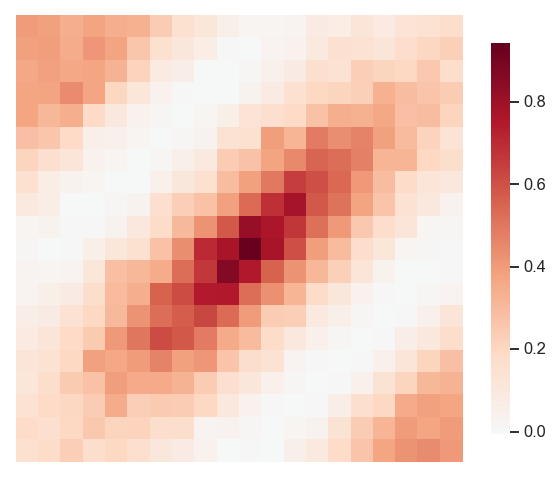

In [135]:
heatmap(np.array(l['none']))
print(np.mean(np.array(l['none'])))

0.22462526499818608


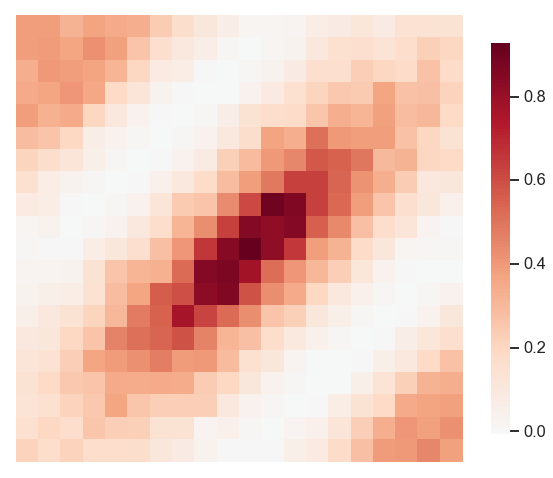

In [136]:
heatmap(np.array(l['reflect']))
print(np.mean(np.array(l['reflect'])))

0.2198022035815347


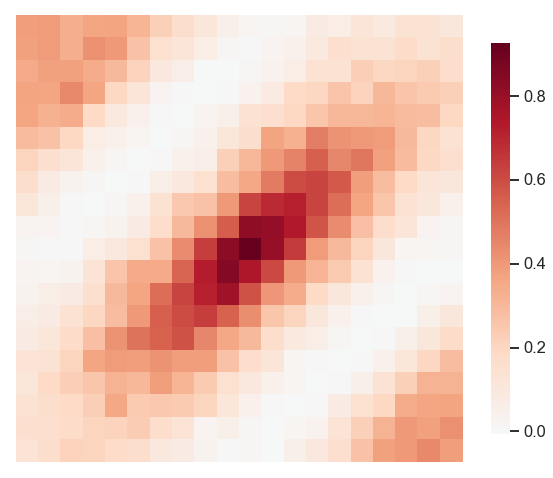

In [137]:
heatmap(np.array(l['procrust']))
print(np.mean(np.array(l['procrust'])))

0.22003708462778251


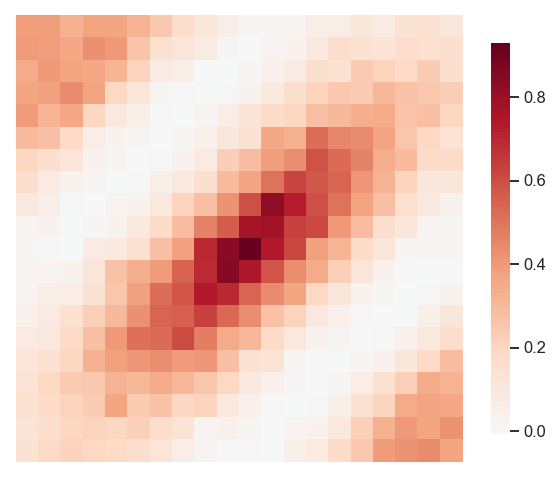

In [138]:
heatmap(np.array(l['reflect-procrust']))
print(np.mean(np.array(l['reflect-procrust'])))

0.0037662959216435586


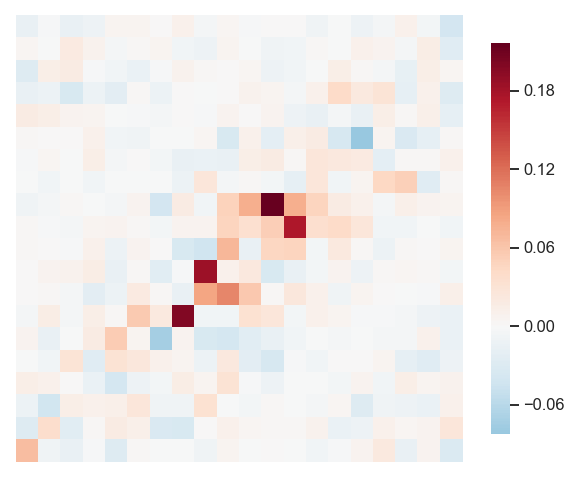

In [139]:
heatmap(np.array(l['reflect'])-np.array(l['none']))
print(np.mean(np.array(l['reflect'])-np.array(l['none'])))

-0.0010567654950078065


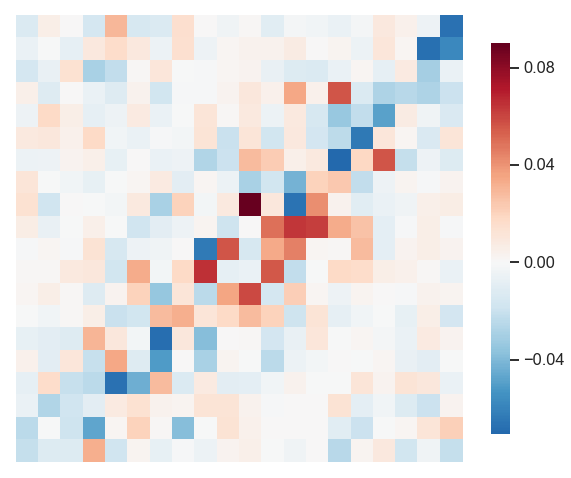

In [140]:
heatmap(np.array(l['procrust'])-np.array(l['none']))
print(np.mean(np.array(l['procrust'])-np.array(l['none'])))

-0.0008218844487600173


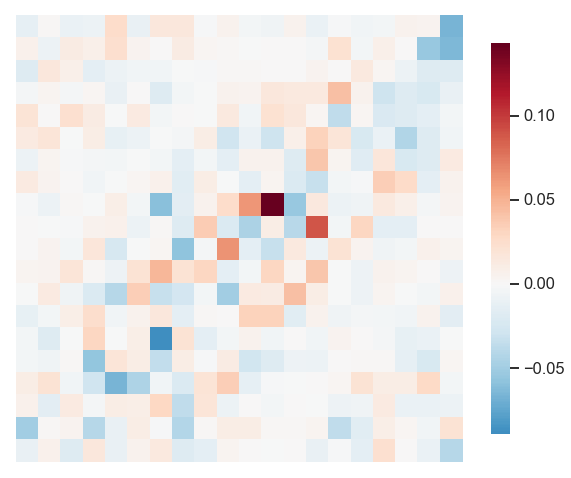

In [141]:
heatmap(np.array(l['reflect-procrust'])-np.array(l['none']))
print(np.mean(np.array(l['reflect-procrust'])-np.array(l['none'])))